In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pwd

/content


In [4]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# convert data to a normalized torch.FloatTensor
train_transforms= transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])])


test_transforms = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                [0.5, 0.5, 0.5])])

data_path = '/content/drive/MyDrive/horse-or-human/train'
train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=train_transforms
    )
data_path = '/content/drive/MyDrive/horse-or-human/validation'
test_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=test_transforms
    )

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )

(32, 3, 224, 224)
(32, 224, 224)


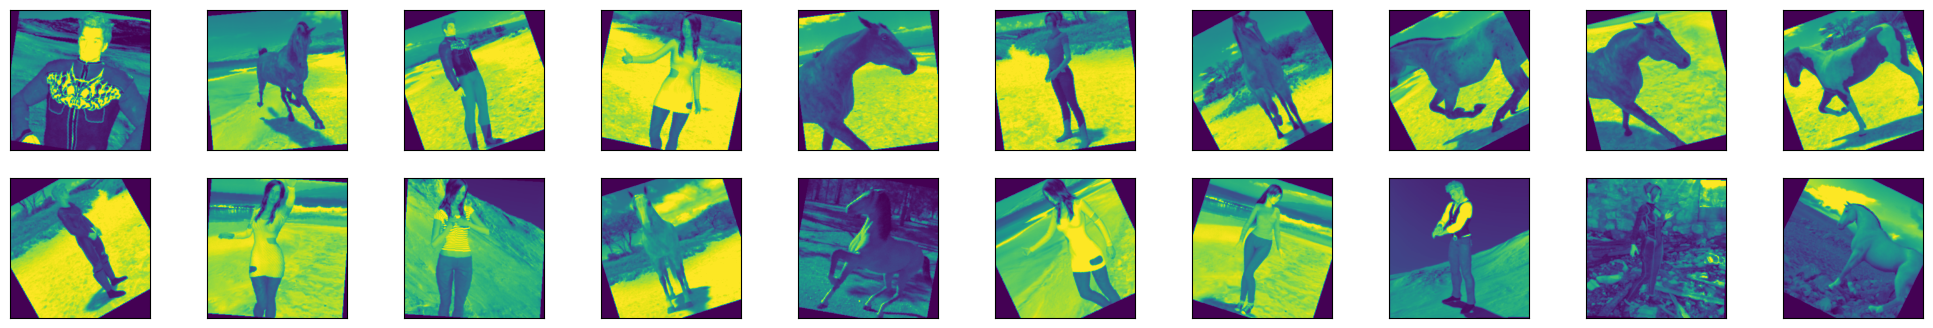

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
print(images.shape)
images = images[:,0,:,:]
print(images.shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))

# Model from Scratch

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3)
        # convolutional layer (sees 111x111x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3)
        # convolutional layer (sees 54x54x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3)
        # convolutional layer (sees 26x26x64 tensor)
        self.conv4 = nn.Conv2d(64, 64, 3)
        # convolutional layer (sees 12x12x64 tensor)
        self.conv5 = nn.Conv2d(64, 64, 3)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 5 * 5 -> 500)
        self.fc1 = nn.Linear(1600, 512)
        # linear layer (512 -> 1)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
#         dropout_layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        # flatten image input
        x = x.view(-1, 64 * 5 * 5)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = self.fc2(x)
        x = self.dropout(x)
        # add 3rd hidden layer
        x = self.fc3(x)

        return x
## complete this function
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    # m.weight.data shoud be taken from a normal distribution
    # m.bias.data should be 0
    if classname.find('Linear') != -1:
    # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

# create a complete CNN
model = Net()
# model.apply(weights_init_normal)
# print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [10]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.BCEWithLogitsLoss()

# specify optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [11]:
# number of epochs to train the model
n_epochs = 15
test_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    test_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        target = target.unsqueeze(1)
#         print(target.size())
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        target = target.float()
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in test_loader:
        target = target.unsqueeze(1)

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        target = target.float()
        loss = criterion(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader)
    test_loss = test_loss/len(test_loader)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, test_loss))

    if test_loss < test_loss_min:
    # save model if validation loss has decreased
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      test_loss_min,
      test_loss))
      torch.save(model.state_dict(), 'model_horse_humans.pt')
      test_loss_min = test_loss

Epoch: 1 	Training Loss: 48.925477 	Validation Loss: 22.322938
Validation loss decreased (inf --> 22.322938).  Saving model ...
Epoch: 2 	Training Loss: 20.839613 	Validation Loss: 43.957950
Epoch: 3 	Training Loss: 19.158754 	Validation Loss: 10.860845
Validation loss decreased (22.322938 --> 10.860845).  Saving model ...
Epoch: 4 	Training Loss: 14.288405 	Validation Loss: 8.576951
Validation loss decreased (10.860845 --> 8.576951).  Saving model ...
Epoch: 5 	Training Loss: 12.093760 	Validation Loss: 36.508478
Epoch: 6 	Training Loss: 7.544255 	Validation Loss: 32.292178
Epoch: 7 	Training Loss: 6.152378 	Validation Loss: 40.373013
Epoch: 8 	Training Loss: 6.083449 	Validation Loss: 32.172143
Epoch: 9 	Training Loss: 4.656306 	Validation Loss: 121.575550
Epoch: 10 	Training Loss: 2.429247 	Validation Loss: 83.359606
Epoch: 11 	Training Loss: 5.951592 	Validation Loss: 55.839838
Epoch: 12 	Training Loss: 2.033759 	Validation Loss: 71.810926
Epoch: 13 	Training Loss: 2.342495 	Valida

# Accuracy

In [12]:
model.load_state_dict(torch.load("model_horse_humans.pt"))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [13]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc.item()

In [14]:
accuracies = []
for data, target in test_loader:
    target = target.unsqueeze(1)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    target = target.float()
    accuracies.append(binary_acc(output, target))
print("Accuracy: ", sum(accuracies)/len(accuracies), "%")

Accuracy:  91.625 %


# Resnet-50 Backbone Finetuning

In [6]:
from torchvision.models import resnet50, ResNet50_Weights

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
class attaching_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(2048,512)
        self.linear2=nn.Linear(512,256)
        self.linear3=nn.Linear(256,64)
        self.linear4=nn.Linear(64,16)
        self.linear5=nn.Linear(16,2)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        return x

In [9]:
model.fc = attaching_model()

In [10]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda() # inplace operation

In [11]:
for param in model.parameters():
        param.requires_grad = False
for param in model.fc.parameters():
        param.requires_grad = True

In [12]:
criterion = nn.CrossEntropyLoss().to("cuda")

In [13]:
import torch.optim as optim

optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [14]:
# number of epochs to train the model
n_epochs = 15
test_loss_min = np.Inf # track change in validation loss
accuracies = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    test_loss = 0.0
    running_score = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)

        val, index_ = torch.max(output, axis=1)
        running_score += torch.sum(index_ == target.data).item()

        # update average validation loss
        test_loss += loss.item()*data.size(0)

    # calculate average losses
    epoch_score = running_score/len(test_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, test_loss))

    if test_loss < test_loss_min:
    # save model if validation loss has decreased
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      test_loss_min,
      test_loss))
      torch.save(model.state_dict(), 'model_horse_humans.pt')
      test_loss_min = test_loss
      print("Accuracy: ", epoch_score, "%")

Epoch: 1 	Training Loss: 0.353086 	Validation Loss: 0.015783
Validation loss decreased (inf --> 0.015783).  Saving model ...
Accuracy:  0.9921875 %
Epoch: 2 	Training Loss: 0.023577 	Validation Loss: 0.042914
Epoch: 3 	Training Loss: 0.007697 	Validation Loss: 0.000320
Validation loss decreased (0.015783 --> 0.000320).  Saving model ...
Accuracy:  1.0 %
Epoch: 4 	Training Loss: 0.005378 	Validation Loss: 0.001165
Epoch: 5 	Training Loss: 0.000379 	Validation Loss: 0.000318
Validation loss decreased (0.000320 --> 0.000318).  Saving model ...
Accuracy:  1.0 %
Epoch: 6 	Training Loss: 0.000284 	Validation Loss: 0.000130
Validation loss decreased (0.000318 --> 0.000130).  Saving model ...
Accuracy:  1.0 %
Epoch: 7 	Training Loss: 0.000137 	Validation Loss: 0.000324
Epoch: 8 	Training Loss: 0.013161 	Validation Loss: 0.004493
Epoch: 9 	Training Loss: 0.000253 	Validation Loss: 0.001791
Epoch: 10 	Training Loss: 0.000629 	Validation Loss: 0.000069
Validation loss decreased (0.000130 --> 0.00

In [15]:
model.load_state_dict(torch.load("model_horse_humans.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
def acc(y_pred, y_test):
    val, index_ = torch.max(y_pred, axis=1)
    running_acc += torch.sum(index_ == y_test.data).item()

In [17]:
class_names = test_loader.dataset.classes

In [18]:
running_acc = 0
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # calculating_accuracy
    val, index_ = torch.max(output, axis=1)
    running_acc += torch.sum(index_ == target.data).item()

print("Accuracy: ", running_acc/len(test_loader.dataset))

Accuracy:  1.0


In [23]:
def imshow(inp, model=model, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # width, height, channel
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

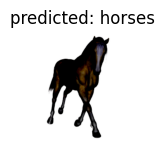

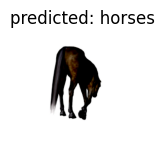

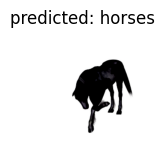

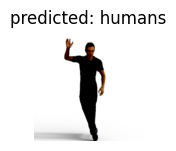

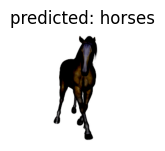

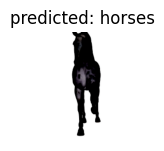

In [24]:
visualize_model(model)